<a href="https://colab.research.google.com/github/Matheus2608/Data-Science/blob/main/Projeto3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fazendo segmentação de instâncias de doenças em morangos

## Importando dataset do Kaggle de imagens de morangos com doenças
Para isso, eu fiz o download por linha de comando pelo dataset ser pesado. De referência segui os passos desse site: https://www.analyticsvidhya.com/blog/2021/04/how-to-download-kaggle-datasets-using-jupyter-notebook/

Mas para isso é necessário ter uma conta no kaggle, se você não tiver sugiro que entre no link que estou fazendo o download do dataset e faça o download pra sua máquina e depois transfira para o Colab

In [ ]:
!pip install opendatasets
import opendatasets as od

In [2]:
od.download("https://www.kaggle.com/datasets/usmanafzaal/strawberry-disease-detection-dataset")

Skipping, found downloaded files in "./strawberry-disease-detection-dataset" (use force=True to force download)


## Treinando Yolact ++
## Setup Inicial
- Para utilizar esse modelo, é necessário importar algumas bibliotecas antes


In [ ]:
# Cython precisa ser instalado antes de pycocotools
!pip install cython
!pip install opencv-python pillow pycocotools matplotlib

#DCNv2
!pip install torchvision==0.5.0
!pip install torch==1.4.0

## Importando o código da Yolact do github dos autores dela

In [4]:
# Clone the repo
!git clone https://github.com/dbolya/yolact.git

fatal: destination path 'yolact' already exists and is not an empty directory.


## DCNv2
É necessário contruir essa biblioteca, **mas** para isso é necessário que o colab esteja rodando no modo GPU

Para isso:
- Clique em Editar > COnfigurações de Notebook
- Coloque GPU como seu hardware e salve


In [ ]:
%cd /content/yolact/external/DCNv2
!python setup.py build develop

## Pesos
- Para não demorar muito o treinamento, vou usar pesos de outro modelo ja treinado
- Tentei de quase todos jeitos possíveis usando comando, mas o yolact não funciona.
- É necessário baixar o peso no github e exportar para esse colab

In [ ]:
%cd /content/yolact
%mkdir weights

In [ ]:
!gdown "https://drive.google.com/uc?id=15id0Qq5eqRbkD-N3ZjDZXdCvRyIaHpFB&export=download" -O "./weights/yolact_plus_base_54_800000.pth"

## Formatando a base de dados

In [ ]:
!pip install -U labelme2coco

In [ ]:
%cd /content/yolact/data/

# import functions
from labelme2coco import get_coco_from_labelme_folder, save_json

# set labelme training data directory
labelme_train_folder = "/content/strawberry-disease-detection-dataset/train/"

# set labelme validation data directory
labelme_val_folder = "/content/strawberry-disease-detection-dataset/val/"

# set path for coco json to be saved
export_dir = "/content/"

# create train coco object
train_coco = get_coco_from_labelme_folder(labelme_train_folder)

# export train coco json
save_json(train_coco.json, export_dir+"train.json")

# create val coco object
val_coco = get_coco_from_labelme_folder(labelme_val_folder, coco_category_list=train_coco.json_categories)

# export val coco json
save_json(val_coco.json, export_dir+"val.json")

In [ ]:
# Fazendo diretório para as imagens
%cd /content/
%mkdir train_images valid_images test_images

#Transferindo as imagens dentro do dataset para o direotrio root
%cd /content/strawberry-disease-detection-dataset/train
%mv *.jpg ../../train_images/
%cd ../val/
%mv *.jpg ../../valid_images/
%cd ../test
%mv *.jpg ../../test_images/

## Agora que o dataset está formatado do jeito que é necessário, é preciso mudar o arquivo config.py eyolact.py


In [ ]:
'''
# ----------------------- DATASETS ----------------------- #
...

my_custom_dataset = dataset_base.copy({
    'name': 'Doença de Morango',

    'train_images': '/content/train_images',
    'train_info':   '/content/train.json',

    'valid_images': '/content/valid_images',
    'valid_info':   '/content/val.json',

    'has_gt': True,
    'class_names': ("Leaf Spot", "Powdery Mildew Leaf", "Gray Mold", "Anthracnose Fruit Rot", "Angular Leafspot", "Powdery Mildew Fruit", "Blossom Blight"),
    'label_map': {0:1, 1:2, 2:3, 3:4, 4:5, 5:6, 6:7}
})

# ----------------------- CONFIG DEFAULTS ----------------------- #

coco_base_config = Config({
    'dataset': my_custom_dataset,
    'num_classes': len(my_custom_dataset.class_names) + 1, # This should include the background class,
    

# ----------------------- YOLACT++ CONFIGS ----------------------- #

yolact_plus_base_config = yolact_base_config.copy({
    'name': 'yolact_plus_base',
    'dataset': my_custom_dataset,
    'num_classes': len(my_custom_dataset.class_names) + 1,
    'backbone': resnet101_dcn_inter3_backbone.copy({
        'selected_layers': list(range(1, 4)),
        
        'pred_aspect_ratios': [ [[1, 1/2, 2]] ]*5,
        'pred_scales': [[i * 2 ** (j / 3.0) for j in range(3)] for i in [24, 48, 96, 192, 384]],
        'use_pixel_scales': True,
        'preapply_sqrt': False,
        'use_square_anchors': False,
    }),

    'use_maskiou': True,
    'maskiou_net': [(8, 3, {'stride': 2}), (16, 3, {'stride': 2}), (32, 3, {'stride': 2}), (64, 3, {'stride': 2}), (128, 3, {'stride': 2})],
    'maskiou_alpha': 25,
    'rescore_bbox': False,
    'rescore_mask': True,

    'discard_mask_area': 5*5,
})
'''

#no arquivo yolact.py
'''
linha 490
try:
    self.load_state_dict(state_dict)
except RuntimeError as e:
    print('Ignoring "' + str(e) + '"')

linha 631
p = pred_layer(pred_x.detach())

'''



In [11]:
# !python train.py --config=yolact_plus_base_config --resume=weights/yolact_plus_base_54_800000.pth  --start_iter=0

In [12]:
# !python train.py --config=yolact_plus_base_config --resume=weights/yolact_plus_base_5_910_interrupt.pth --save_folder checkpoint_models --start_iter=-1

In [ ]:
!python train.py --config=yolact_plus_base_config --resume=weights/yolact_plus_base_11_1991_interrupt.pth --start_iter=-1

In [26]:
!python eval.py --config=yolact_plus_base_config --trained_model=weights/yolact_plus_base_11_1991_interrupt.pth 

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Loading model... Done.

Processing Images  ██████████████████████████████    307 /    307 (100.00%)     4.52 fps        
Saving data...
Calculating mAP...

       |  all  |  .50  |  .55  |  .60  |  .65  |  .70  |  .75  |  .80  |  .85  |  .90  |  .95  |
-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+
   box | 55.27 | 79.83 | 77.90 | 76.13 | 74.94 | 69.92 | 64.53 | 58.42 | 36.53 | 13.44 |  1.03 |
  mask | 51.18 | 69.42 | 67.13 | 65.83 | 64.32 | 61.74 | 58.37 | 53.35 | 44.12 | 21.11 |  6.42 |
-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+-------+



In [ ]:
!python eval.py --config=yolact_plus_base_config --trained_model=weights/yolact_plus_base_11_1991_interrupt.pth --images=../valid_images:../output_valid_images --score_threshold=0.2 --top_k=20

In [ ]:
!python eval.py --config=yolact_plus_base_config --trained_model=weights/yolact_plus_base_11_1991_interrupt.pth --images=../test_images:../output_test_images --score_threshold=0.2 --top_k=20

/content/output_test_images


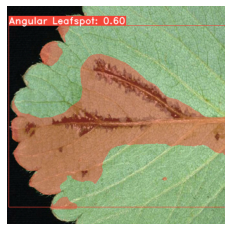

In [41]:
%matplotlib inline
import os
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
#plt.figure(figsize=(24, 18))
%cd /content/output_test_images/
img = mpimg.imread('/content/output_test_images/angular_leafspot359.png')
#fotos = os.listdir()
plt.imshow(img)
plt.axis('off')

img = mpimg.imread('/content/output_test_images/angular_leafspot364.png')
plt.imshow(img)
plt.axis('off')

plt.show()


# cont = 0
# for foto in fotos:
#   if cont == 1:
#     break
#   #ax = plt.subplot(10, 1, cont + 1)
#   img = mpimg.imread(foto)
#   plt.imshow(img)
#   plt.axis('off') 
#   cont += 1
# plt.show()

## Yolact++
@article{yolact-plus-tpami2020,

  author  = {Daniel Bolya and Chong Zhou and Fanyi Xiao and Yong Jae Lee},

  journal = {IEEE Transactions on Pattern Analysis and Machine Intelligence}, 

  title   = {YOLACT++: Better Real-time Instance Segmentation}, 

  year    = {2020},
  
}

## Dataset
Afzaal, U.; Bhattarai, B.; Pandeya, Y.R.; Lee, J. An Instance Segmentation Model for Strawberry Diseases Based on Mask R-CNN. Sensors 2021, 21, 6565

In [ ]:
# %cd /content/
# %rm -rf strawberry-disease-detection-dataset
# %rm -rf yolact
# %rm -rf train.json val.json
# %rm -rf train_images/ valid_images/ view

## Referências:
- https://github.com/dbolya/yolact/issues/334
- https://github.com/dbolya/yolact/issues/36
- https://github.com/dbolya/yolact/issues/58
- https://www.immersivelimit.com/tutorials/yolact-with-google-colab